# Run the new method on one bin to test the method

In [1]:
import copy
import os

from astropy.constants import G
import astropy.table as at
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from astropy.io import fits
import tqdm

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
import gala.integrate as gi
from gala.units import galactic

import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline

import torusimaging as oti
from torusimaging import LabelOrbitModel
# from empaf import DensityOrbitModel
from torusimaging.plot import plot_data_models_residual
from torusimaging.model_helpers import generalized_logistic_func_alt
from astropy.stats import median_absolute_deviation as MAD
from model_maker import SplineLabelModelWrapper
import utils
from torusimaging import model

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import nmmn.plots
import vorbin
wolfram=nmmn.plots.wolframcmap() # for Mathematica's cmap
parula=nmmn.plots.parulacmap() # for MATLAB's cmap
turbo=nmmn.plots.turbocmap() # Turbo
import warnings
warnings.filterwarnings('ignore')


# Load in the data

In [2]:
# LOAD THE DATA
# this is the latest APOGEE catalogue that APW sent me with orbital properties determined using StarHorse distances

path = '/Users/dhortadarrington/Documents/Master/data/allstar-dr17-StarHorse-Gaiadr3'
tb = fits.open(path)
data = tb[1].data 

In [3]:
# load in the mask for the lowalpha disc
lowa = np.load('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/sav/lowa_mask.npy',allow_pickle=True)

# Define the bins

In [4]:
import astropy.units as u
x = data['xyz'][:,0]
y = data['xyz'][:,1]
z = data['xyz'][:,2]
vx = data['vxyz'][:,0]
vy = data['vxyz'][:,1]
vz = data['vxyz'][:,2]
vz = (vz*u.km/u.s)
vz = vz.to(u.kpc/u.Gyr)
x = x*u.kpc
y = y*u.kpc
z = z*u.kpc

# Eilers rotation curve
Rgal = np.sqrt(data['xyz'][:,0]**2+data['xyz'][:,1]**2)
vcirc = 229.-1.7*(Rgal-8.275)
Rg = -(data['L'][:,2]/vcirc)
deltaR = Rgal-Rg
phi = np.arctan(data['xyz'][:,1]/data['xyz'][:,0])

#transform to cylindrical velocities
vr = +data['vxyz'][:,0]*np.cos(phi)+data['vxyz'][:,1]*np.sin(phi)
vt = -data['vxyz'][:,0]*np.sin(phi)+data['vxyz'][:,1]*np.cos(phi)

# so that we can apply OTI, we need to have some good approximation to circular orbits that are decomposable in R and z
# omask = (np.fabs(z)<2*u.kpc)&(np.fabs(vz)<80*u.kpc/u.Gyr)&(np.fabs(deltaR)<3)
omask = (np.abs(z)<2*u.kpc)&(np.abs(vz)<80*u.kpc/u.Gyr)&(np.abs(deltaR)<1)&(np.abs(vr)<50)
# &(data['ecc']<0.2)
lowa_omask = lowa&omask
# lowa_omask2 = lowa&omask2

print('There are '+str(len(data[lowa]))+' stars in the parent sample')
print('There are '+str(len(data[lowa_omask]))+' stars in the sample we model')

There are 172656 stars in the parent sample
There are 94685 stars in the sample we model


# Plot the data, model, and residuals in three $R_{g}$ bins

In [5]:
Rg_l, Rg_r = (7., 9.)

Rg_mask = (Rg > Rg_l) & (Rg <= Rg_r)

oti_data = oti.OTIData(
    pos=z[Rg_mask&lowa_omask],
    vel=vz[Rg_mask&lowa_omask],
    labels=dict(mgfe=data['MG_FE'][Rg_mask&lowa_omask]),
    label_errs=dict(mgfe=data['MG_FE_ERR'][Rg_mask&lowa_omask]),
)
print(np.max(oti_data.vel))

max_z = 2 * np.nanpercentile(np.abs(oti_data.pos), 90)
max_vz = 2 * np.nanpercentile(np.abs(oti_data.vel), 90).to(u.km / u.s)
max_z, max_vz

zbins = np.linspace(-1, 1, 101) * max_z
vzbins = np.linspace(-1, 1, 101) * max_vz
zvz_bins = {"pos": zbins, "vel": vzbins}

0.07955937343178489 kpc / Myr


In [7]:
Rg_cs = np.linspace(8,10,3)

oti_datas = []
bdatas = []
reses = []

for indx, Rg_c in enumerate(Rg_cs):
    Rg_l, Rg_r = (Rg_c, Rg_c + 1)
    Rg_mask = (Rg > Rg_l) & (Rg <= Rg_r)

    oti_data = oti.OTIData(
        pos=z[Rg_mask&lowa_omask],
        vel=vz[Rg_mask&lowa_omask],
        labels=dict(mgfe=data['MG_FE'][Rg_mask&lowa_omask]),
        label_errs=dict(mgfe=data['MG_FE_ERR'][Rg_mask&lowa_omask]),
    )
    oti_datas.append(oti_data)
        
    cdata = oti_data.get_binned_counts(zvz_bins)
    bdata, _ = oti_data.get_binned_label(bins=zvz_bins)
    bdatas.append(bdata)
    
    std_im = bdata['mgfe_err'] * np.sqrt(cdata['counts'])
    std_im[cdata['counts'] < 10] = np.nan

    ell_mask = np.abs(bdata['mgfe'] - np.nanpercentile(oti_data.labels['mgfe'], 15)) < 3 * np.nanmean(std_im)
    tmpv = bdata['vel'][ell_mask]
    tmpz = bdata['pos'][ell_mask]
    init_Omega = MAD(tmpv) / MAD(tmpz) * u.rad

    max_re = np.mean(
        [
            (max_z * np.sqrt(init_Omega)).decompose(galactic).value,
            (max_vz / np.sqrt(init_Omega)).decompose(galactic).value,
        ]
        )

    model = SplineLabelModelWrapper(
        r_e_max=max_re,
        label_n_knots=9,
        label0_bounds=(-1.0, 1.0),
        label_grad_sign=1.0,
        label_regularize_sigma=1.0,
        label_smooth_sigma=0.2,
        e_n_knots={2: 8, 4: 4},
        e_knots_scale={2: (lambda x: x ** (3 / 2), lambda x: x ** (2 / 3))},
        e_regularize_sigmas={2: 0.1, 4: 0.1},
        e_smooth_sigmas={2: 0.2, 4: 0.2},
        )

    p0 = model.get_init_params(oti_data)
    p0["e_params"][2]["vals"] = np.full_like(p0["e_params"][2]["vals"], -0.25)
    p0["e_params"][4]["vals"] = np.full_like(p0["e_params"][4]["vals"], np.log(0.1 / max_re))
    
    bdata, res = model.run(
        bdata,
        p0=p0,
        label_name="mgfe",
        bins=zvz_bins,
        jaxopt_kw=dict(maxiter=32768, tol=1e-10)
        )
    reses.append(res)




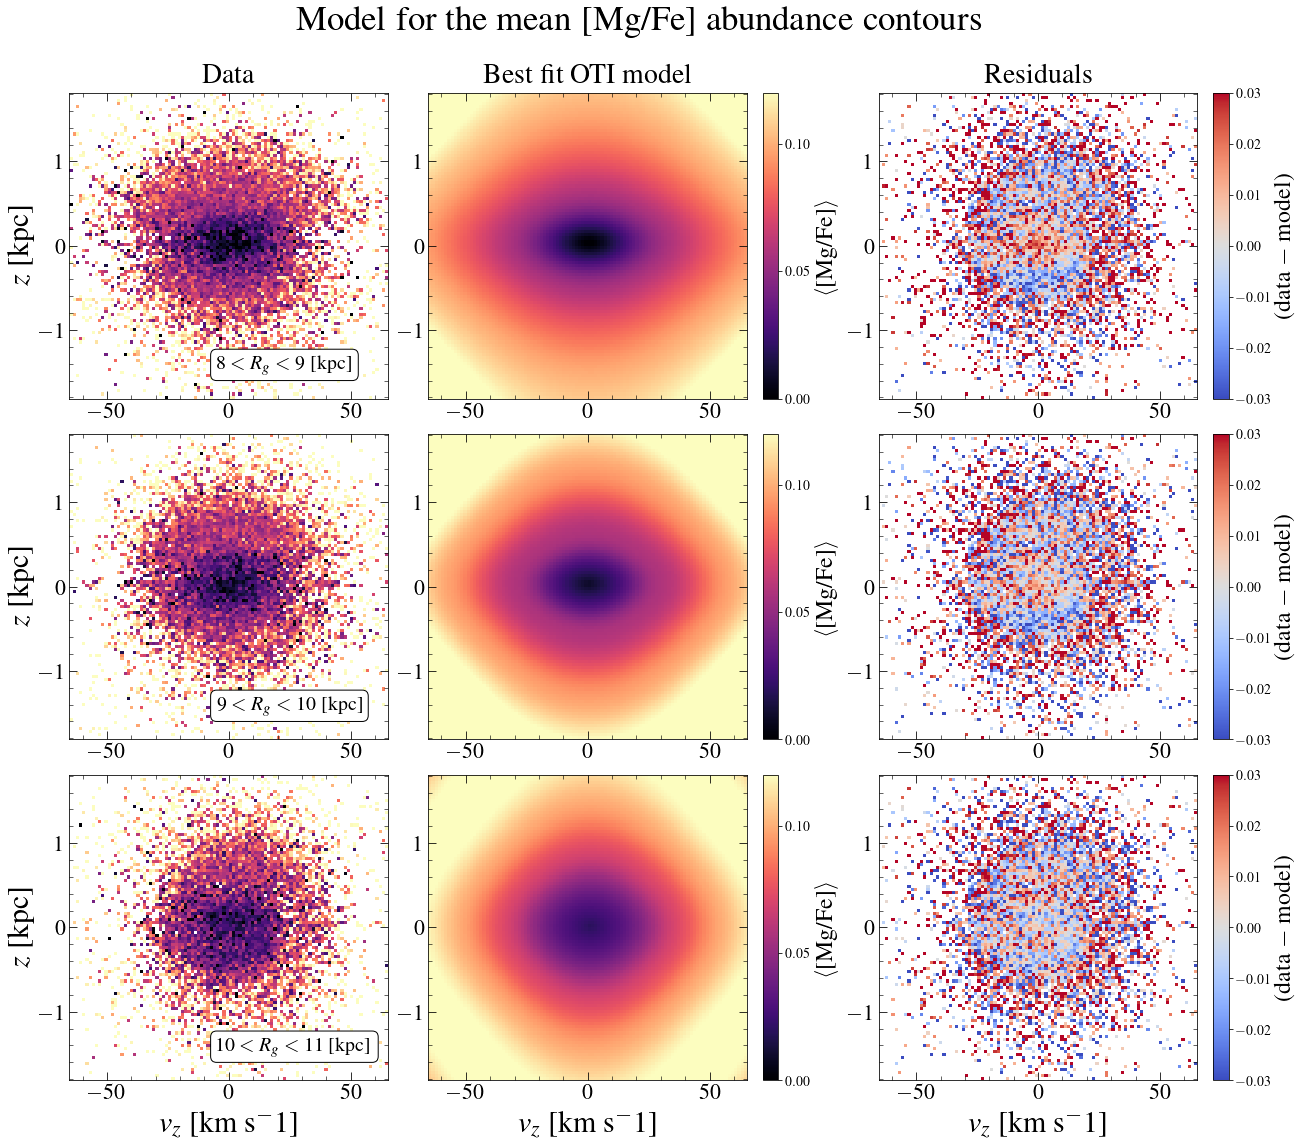

In [9]:
mgfe_cbar_vlim = [0.,0.12]
mgfe_cbar_xlim = [0.,0.12]
cb_labelsize = 24
res_lim = 0.03

fig, axes = plt.subplots(3,3,figsize=(18, 15), constrained_layout=True, facecolor='white')
fig.suptitle('Model for the mean [Mg/Fe] abundance contours',fontsize=35,x=0.49,y=1.05)

datos = bdatas[0]

cs = axes[0,0].pcolormesh(
    datos["vel"].to_value(u.km / u.s),
    datos["pos"].to_value(u.kpc),
    datos["mgfe"],
    cmap="magma",
    rasterized=True,
    vmin=mgfe_cbar_vlim[0],
    vmax=mgfe_cbar_vlim[1],
    )
axes[0,0].tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=8)
axes[0,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[0,0].minorticks_on()
props = dict(boxstyle='round', facecolor='white', alpha=1)
axes[0,0].text(-5,-1.3, r'$8< R_{g} <9$ [kpc]', fontsize=20,
    verticalalignment='top', bbox=props)

model_mgfe = np.array(model.label_model.label(datos["pos"], datos["vel"], reses[0].params))

cs = axes[0,1].pcolormesh(
    datos["vel"].to_value(u.km / u.s),
    datos["pos"].to_value(u.kpc),
    model_mgfe,
    cmap="magma",
    rasterized=True,
#         vmin=mgfe_cbar_vlim[0],
#         vmax=mgfe_cbar_vlim[1],
    vmin=mgfe_cbar_vlim[0],
    vmax=mgfe_cbar_vlim[1],
)
axes[0,1].tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=8)
axes[0,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[0,1].minorticks_on()
cb = fig.colorbar(cs, ax=axes[0,1])
cb.set_label(r"$\langle$[Mg/Fe]$\rangle$", fontsize=cb_labelsize)
cb.ax.set_ylim(mgfe_cbar_xlim)
cb.ax.set_yticks(np.arange(mgfe_cbar_xlim[0], mgfe_cbar_xlim[1] + 1e-3, 0.05))
cb.ax.yaxis.set_tick_params(labelsize=14)


cs = axes[0,2].pcolormesh(
    bdata["vel"].to_value(u.km / u.s),
    bdata["pos"].to_value(u.kpc),
#     (bdata["mgfe"] - model_mgfe)/ bdata["mgfe_err"] / np.sqrt(2),
    (bdata["mgfe"] - model_mgfe),
    cmap="coolwarm",
    vmin=-res_lim,
    vmax=res_lim,
    rasterized=True,
)
axes[0,2].tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=8)
axes[0,2].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[0,2].minorticks_on()
cb = fig.colorbar(cs, ax=axes[0,2])  # , orientation="horizontal")
cb.set_label("(data $-$ model)", fontsize=cb_labelsize)
cb.ax.yaxis.set_tick_params(labelsize=14)


#------------------

datos = bdatas[1]

cs = axes[1,0].pcolormesh(
    datos["vel"].to_value(u.km / u.s),
    datos["pos"].to_value(u.kpc),
    datos["mgfe"],
    cmap="magma",
    rasterized=True,
    vmin=mgfe_cbar_vlim[0],
    vmax=mgfe_cbar_vlim[1],
)
axes[1,0].tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=8)
axes[1,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[1,0].minorticks_on()
props = dict(boxstyle='round', facecolor='white', alpha=1)
axes[1,0].text(-5,-1.3, r'$9< R_{g} <10$ [kpc]', fontsize=20,
    verticalalignment='top', bbox=props)

model_mgfe = np.array(model.label_model.label(datos["pos"], datos["vel"], reses[1].params))

cs = axes[1,1].pcolormesh(
    datos["vel"].to_value(u.km / u.s),
    datos["pos"].to_value(u.kpc),
    model_mgfe,
    cmap="magma",
    rasterized=True,
#         vmin=mgfe_cbar_vlim[0],
#         vmax=mgfe_cbar_vlim[1],
    vmin=mgfe_cbar_vlim[0],
    vmax=mgfe_cbar_vlim[1],
)
axes[1,1].tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=8)
axes[1,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[1,1].minorticks_on()
cb = fig.colorbar(cs, ax=axes[1,1])
cb.set_label(r"$\langle$[Mg/Fe]$\rangle$", fontsize=cb_labelsize)
cb.ax.set_ylim(mgfe_cbar_xlim)
cb.ax.set_yticks(np.arange(mgfe_cbar_xlim[0], mgfe_cbar_xlim[1] + 1e-3, 0.05))
cb.ax.yaxis.set_tick_params(labelsize=14)


cs = axes[1,2].pcolormesh(
    bdata["vel"].to_value(u.km / u.s),
    bdata["pos"].to_value(u.kpc),
    (bdata["mgfe"] - model_mgfe),
    cmap="coolwarm",
    vmin=-res_lim,
    vmax=res_lim,
    rasterized=True,
)
axes[1,2].tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=8)
axes[1,2].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[1,2].minorticks_on()
cb = fig.colorbar(cs, ax=axes[1,2])  # , orientation="horizontal")
cb.set_label("(data $-$ model)", fontsize=cb_labelsize)
cb.ax.yaxis.set_tick_params(labelsize=14)

# ---------------------------------------

datos = bdatas[2]

cs = axes[2,0].pcolormesh(
    datos["vel"].to_value(u.km / u.s),
    datos["pos"].to_value(u.kpc),
    datos["mgfe"],
    cmap="magma",
    rasterized=True,
    vmin=mgfe_cbar_vlim[0],
    vmax=mgfe_cbar_vlim[1],
)
axes[2,0].tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=8)
axes[2,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[2,0].minorticks_on()
props = dict(boxstyle='round', facecolor='white', alpha=1)
axes[2,0].text(-5,-1.3, r'$10< R_{g} <11$ [kpc]', fontsize=20,
    verticalalignment='top', bbox=props)

model_mgfe = np.array(model.label_model.label(datos["pos"], datos["vel"], reses[2].params))

cs = axes[2,1].pcolormesh(
    datos["vel"].to_value(u.km / u.s),
    datos["pos"].to_value(u.kpc),
    model_mgfe,
    cmap="magma",
    rasterized=True,
#         vmin=mgfe_cbar_vlim[0],
#         vmax=mgfe_cbar_vlim[1],
    vmin=mgfe_cbar_vlim[0],
    vmax=mgfe_cbar_vlim[1],
)
axes[2,1].tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=8)
axes[2,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[2,1].minorticks_on()
cb = fig.colorbar(cs, ax=axes[2,1])
cb.set_label(r"$\langle$[Mg/Fe]$\rangle$", fontsize=cb_labelsize)
cb.ax.set_ylim(mgfe_cbar_xlim)
cb.ax.set_yticks(np.arange(mgfe_cbar_xlim[0], mgfe_cbar_xlim[1] + 1e-3, 0.05))
cb.ax.yaxis.set_tick_params(labelsize=14)


cs = axes[2,2].pcolormesh(
    bdata["vel"].to_value(u.km / u.s),
    bdata["pos"].to_value(u.kpc),
    (bdata["mgfe"] - model_mgfe),
    cmap="coolwarm",
    vmin=-res_lim,
    vmax=res_lim,
    rasterized=True,
)
axes[2,2].tick_params(which='major',labelsize=22,direction='in',top=True,right=True,length=8)
axes[2,2].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[2,2].minorticks_on()
cb = fig.colorbar(cs, ax=axes[2,2])  # , orientation="horizontal")
cb.set_label("(data $-$ model)", fontsize=cb_labelsize)
cb.ax.yaxis.set_tick_params(labelsize=14)

# Titles
title_pad = 10
axes[0,0].set_title("Data", fontsize=28, pad=title_pad)
axes[0,1].set_title("Best fit OTI model", fontsize=28, pad=title_pad)
axes[0,2].set_title("Residuals", fontsize=28, pad=title_pad)
#     fig.suptitle(f"{suptitle1} {suptitle2}", fontsize=24)

# # Labels
# axes[0,0].set_ylabel(f"$z$ [kpc]",fontsize=25)
# axes[1,0].set_ylabel(f"$z$ [kpc]",fontsize=25)
# axes[2,0].set_ylabel(f"$z$ [kpc]",fontsize=25)

for ax in axes[2,:]:
    ax.set_xlabel(f"$v_z$ [km s$^{-1}$]",fontsize=30)
for ax in axes[:,0]:
    ax.set_ylabel(f"$z$ [kpc]",fontsize=30)
    
plt.savefig('/Users/dhortadarrington/Documents/Projects/orbital-torus-imaging/plots_paper/fit-bins-all-resubmit.pdf',dpi=250, bbox_inches = 'tight')

